In [18]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from matplotlib.patches import Patch
import scipy.io
import warnings


from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_auc_score

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import imputation

rocAvA=1.000
rocAvB=0.731
rocAvC=0.768

mannAvA=1.000
mannAvB=0.726
mannAvC=0.742

jacAvA=1.000
jacAvB=0.440
jacAvC=0.409



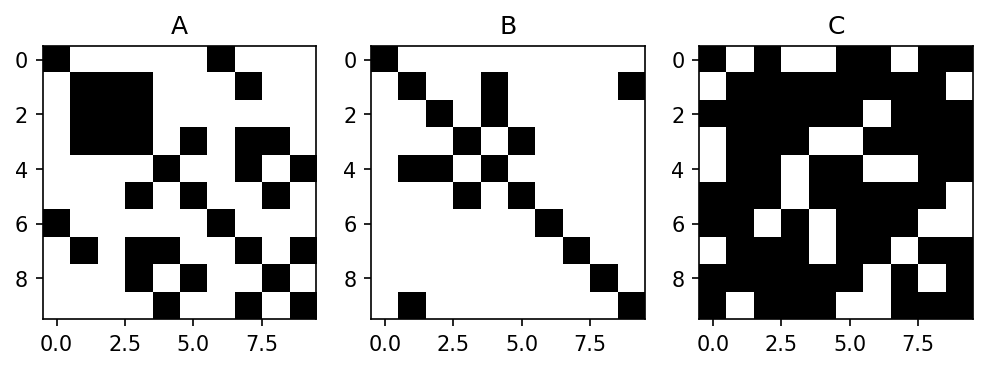

In [2]:
reload(imputation)

# create some random matrices
A = scipy.sparse.random(10, 10, density=0.15)
A = A.todense()
np.fill_diagonal(A, 1)
A = A.T + A
A = np.where(A > 0, 1, 0)

B = scipy.sparse.random(10, 10, density=0.05)
B = B.todense()
B = B.T + B
np.fill_diagonal(B, 1)
B = np.where(B > 0, 1, 0)

C = scipy.sparse.random(10, 10, density=0.45)
C = C.todense()
C = C.T + C
C = np.where(C > 0, 1, 0)


# plot the random matrices

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 8, 8

fig = plt.figure()
fig.add_subplot(131)
plt.imshow(A, cmap='binary')
plt.title("A")

fig.add_subplot(132)
plt.imshow(B, cmap='binary')
plt.title("B")

fig.add_subplot(133)
plt.imshow(C, cmap='binary')
plt.title("C")

# compute the AUCROC scores

rocAvA = roc_auc_score(np.triu(A).ravel(), np.triu(A).ravel())
rocAvB = roc_auc_score(np.triu(A).ravel(), np.triu(B).ravel())
rocAvC = roc_auc_score(np.triu(A).ravel(), np.triu(C).ravel())

print(f"{rocAvA=:.3f}")
print(f"{rocAvB=:.3f}")
print(f"{rocAvC=:.3f}")
print()

_, mannAvA = imputation.mannUManual(np.triu(A).ravel(), np.triu(A).ravel())
_, mannAvB = imputation.mannUManual(np.triu(A).ravel(), np.triu(B).ravel())
_, mannAvC = imputation.mannUManual(np.triu(A).ravel(), np.triu(C).ravel())

print(f"{mannAvA=:.3f}")
print(f"{mannAvB=:.3f}")
print(f"{mannAvC=:.3f}")
print()

jacAvA = jaccard_score(np.triu(A).ravel(), np.triu(A).ravel())
jacAvB = jaccard_score(np.triu(A).ravel(), np.triu(B).ravel())
jacAvC = jaccard_score(np.triu(A).ravel(), np.triu(C).ravel())

print(f"{jacAvA=:.3f}")
print(f"{jacAvB=:.3f}")
print(f"{jacAvC=:.3f}")
print()


In [3]:
# break

# Analysis

In [4]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}

chromOrder = list(chromDict.values())
chromOrder

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chrX',
 'chrY']

In [5]:
scHICfilepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw_BALANCED.scool"
cellList = list(cooler.fileops.list_coolers(scHICfilepath))
print(f"{len(cellList)=}")

len(cellList)=3882


NOTE: the raw data needs to be re-organized prior to extracting a single chromosome.

In [6]:
sampleSize = 1000
chromosome = ['chr2']
sample = np.random.choice(cellList, sampleSize, replace=False)

hic = {}

for i, s in enumerate(sample):
    filetag = "_".join(s.split("_")[0:2]).replace("/", "") + f"_{i}"
    rawMat, hicChromInfo, hicIndex = pcu.loadNagano2017SingleCell(scHICfilepath, s, chromOrder, balance=False)
    
    hicChromInfo = hicChromInfo[hicChromInfo['region'].str.contains('random') == False]
    
    # re-order  the matrix
    hicMat = rawMat[hicIndex, :][:, hicIndex]
    
    # extract the second chromosome
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')

    A = hicMat[chrHicInd, :][:, chrHicInd]
   
    # binarize 
    A = np.where(A > 0, 1, 0)
    hic[filetag] = A
#     print(f"{filetag=} {A.shape=}")
    
print('done.')
print(f"{len(hic.keys())=}")

done.
len(hic.keys())=1000


In [7]:
for k, v in hic.items():
    assert(v.shape == (182, 182))
#     if not v.shape == (182, 182):
#         print(k, v.shape)

(179, 179)


<ipython-input-8-c48030fab071>:23: RuntimeWarning: divide by zero encountered in log
  pltEnsemble = np.where(ensembleTrue > 0, np.log(ensembleTrue), ensembleTrue)


Text(0.5, 1.0, 'Ensemble of Binary Single-Cells')

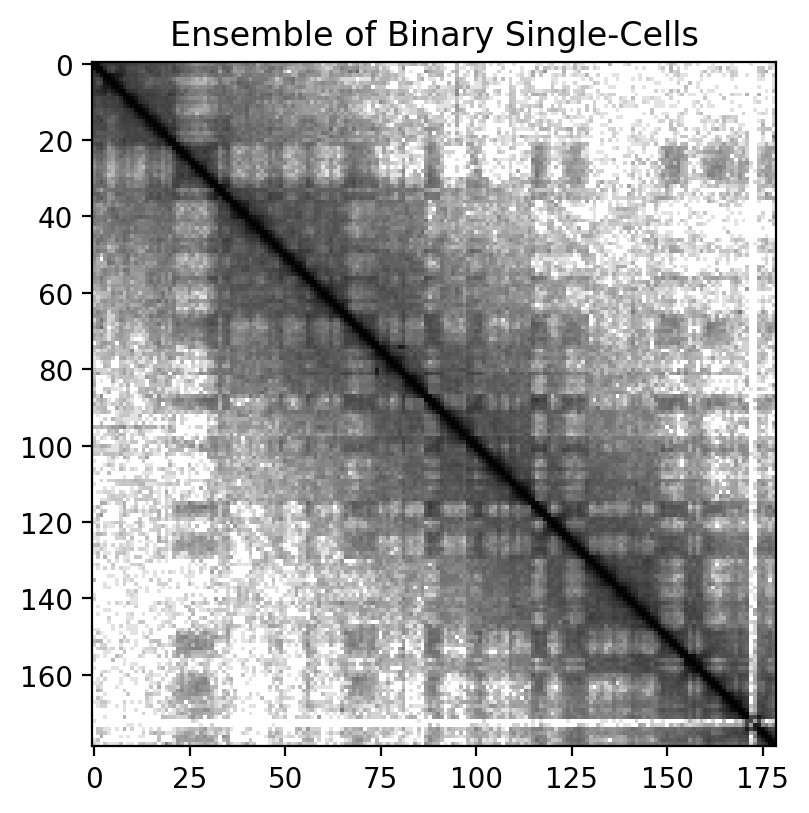

In [8]:
n = 500
sampleKeys = np.random.choice(list(hic.keys()), n)

# generate ensemble data
ensembleTrue = np.zeros((182, 182))

for sampleKey in sampleKeys:
    ensembleTrue += hic[sampleKey]
    
# find indices without contacts
rowsSum = ensembleTrue.sum(axis=0)
rmInd = np.argwhere(rowsSum == 0)

ensembleTrue = np.delete(ensembleTrue, rmInd, axis=0)
ensembleTrue = np.delete(ensembleTrue, rmInd, axis=1)

print(f"{ensembleTrue.shape}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig = plt.figure()

pltEnsemble = np.where(ensembleTrue > 0, np.log(ensembleTrue), ensembleTrue)

fig.add_subplot(131)
plt.imshow(pltEnsemble, cmap='binary')
plt.title(f'Ensemble of Binary Single-Cells')

In [9]:
# remove the missing indices from all matrices

for k, A in hic.items():
    A = np.delete(A, rmInd, axis=0)
    A = np.delete(A, rmInd, axis=1)
    
    hic[k] = A
    
print('done.')

done.


In [10]:
# break

In [11]:
reload(imputation)

retain = 0.25

uniformMissing = imputation.randomUniformRemoval(hic, retain=retain)
print(f"{len(uniformMissing.keys())=}")

degreeLimit = imputation.degreeLimitRemoval(hic, retain=retain)
print(f"{len(degreeLimit.keys())=}")

crawlMissing = imputation.breadthFirstRemoval(hic, retain=retain)
print(f"{len(crawlMissing.keys())=}")

coldEnd = imputation.coldEndRemoval(hic, retain=retain)
print(f"{len(coldEnd.keys())=}")

print('done.')

len(uniformMissing.keys())=1000
len(degreeLimit.keys())=1000
len(crawlMissing.keys())=1000
len(coldEnd.keys())=1000
done.


In [12]:
# break

sampleKey='Diploid_10_129'


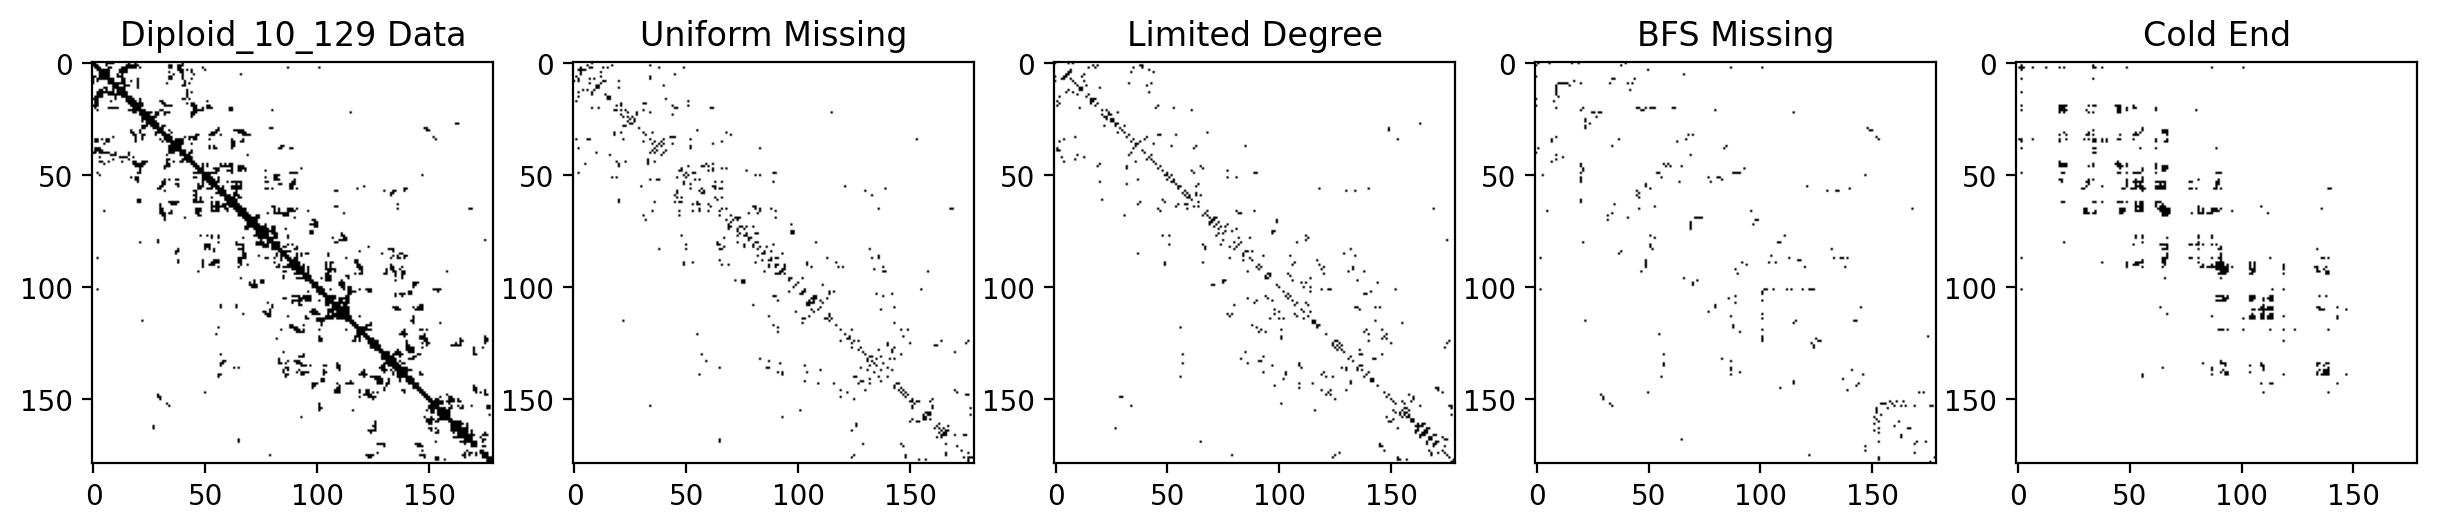

sampleKey='Diploid_3_306'


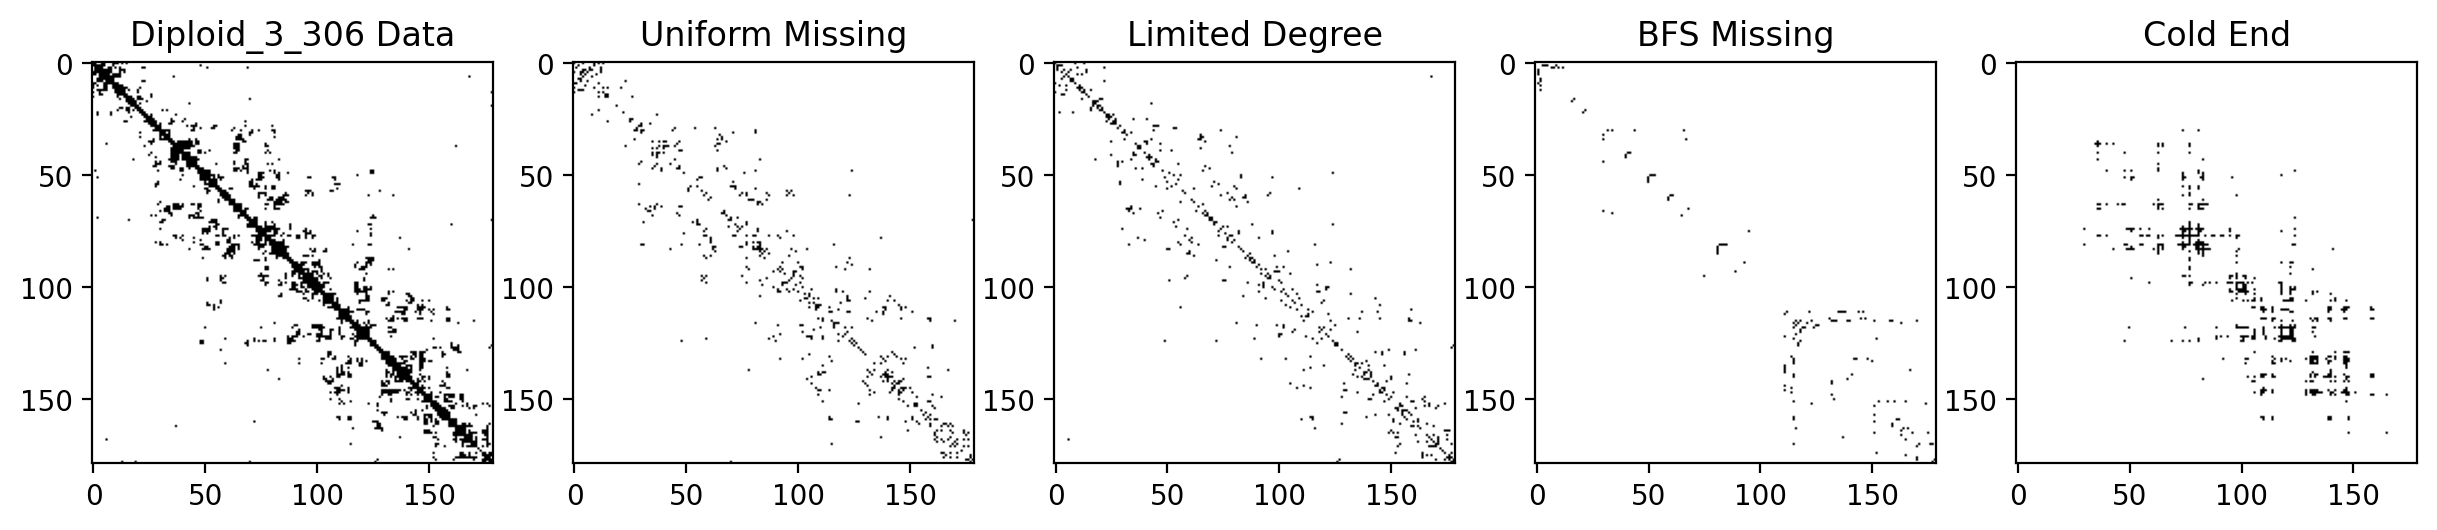

In [13]:
n = 2
sampleKeys = np.random.choice(list(coldEnd.keys()), n)

for sampleKey in sampleKeys:

    print(f"{sampleKey=}")

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 15, 15
    fig = plt.figure()

    fig.add_subplot(151)
    plt.imshow(hic[sampleKey], cmap='binary')
    plt.title(f'{sampleKey} Data')

    fig.add_subplot(152)
    plt.imshow(uniformMissing[sampleKey], cmap='binary')
    plt.title('Uniform Missing')

    fig.add_subplot(153)
    plt.imshow(degreeLimit[sampleKey], cmap='binary')
    plt.title('Limited Degree')

    fig.add_subplot(154)
    plt.imshow(crawlMissing[sampleKey], cmap='binary')
    plt.title('BFS Missing')

    fig.add_subplot(155)
    plt.imshow(coldEnd[sampleKey], cmap='binary')
    plt.title('Cold End')
    
    plt.show()

In [19]:
tau = 0.5

missingType = {
    'Random Uniform' : uniformMissing,
    'Degree Limited' : degreeLimit,
    'Crawl Limited' : crawlMissing,
    'Cold-end Limited' : coldEnd
}

predictionAlgo = {
    'Resource Allocation' : lambda x : imputation.imputeEdges(x, tau, method=1),
    'Preferential Attachment' : lambda x : imputation.imputeEdges(x, tau, method=2),
    'Adamic-Adar' : lambda x : imputation.imputeEdges(x, tau, method=3),
    'CCPA' : lambda x : imputation.imputeEdges(x, tau, method=4),
}

newRows = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for algoName, algoFunc in predictionAlgo.items():
        print(f"{algoName=}")
        for mTypeName, Adict in missingType.items():
            print(f"\t{mTypeName=}")
            for key in hic.keys():

                Atrain = Adict[key]
                Atrue = hic[key]
                Apred, scores = algoFunc(Atrain)

                # AUC computed with scores
                try:
                    AUC = roc_auc_score(np.triu(Atrue).ravel(), 
                                        np.triu(Apred).ravel())
                except ValueError:
                    AUC = 0.5

                _, mannU = imputation.mannUManual(np.triu(Atrue).ravel(), 
                                                  np.triu(Apred).ravel())

                Jaccard = jaccard_score(np.triu(Atrue).ravel(), 
                                        np.triu(Apred).ravel(), 
                                        zero_division='ignore')

                Fnorm = np.linalg.norm(Atrue - Apred)

                nTrue = np.sum(np.sum(Atrue))
                nPred = np.sum(np.sum(Apred))

                tn, fp, fn, tp = confusion_matrix(np.triu(Atrue).ravel(), np.triu(Apred).ravel(), labels=[0, 1]).ravel()

                row = {
                    'cell' : key,
                    'predictionAlgorithm' : algoName,
                    'missingType' : mTypeName,
                    'Jaccard_Index' : Jaccard,
                    'Fnorm' : Fnorm,
                    'AUCROC' : AUC,
                    'MannUAUC' : mannU,
                    'nTrue' : nTrue,
                    'nPred' : nPred,
                    'TrueNegative' : tn,
                    'TruePositive' : tp,
                    'FalseNegative' : fn,
                    'FalsePositive' : fp,
                    'sensitivity' : tp / (tp + fn),
                    'specificity' : tn / (tn + fp),
                    'precision' : tp / (tp + fp),
                    'falseDiscovery' : fp / (fp + tp),
                    'predMatrix' : Apred,
                }
                newRows.append(row)

df = pd.DataFrame(newRows)
print(f"{df.shape=}")
df.head()

algoName='Resource Allocation'
	mTypeName='Random Uniform'
	mTypeName='Degree Limited'
	mTypeName='Crawl Limited'
	mTypeName='Cold-end Limited'
algoName='Preferential Attachment'
	mTypeName='Random Uniform'
	mTypeName='Degree Limited'
	mTypeName='Crawl Limited'
	mTypeName='Cold-end Limited'
algoName='Adamic-Adar'
	mTypeName='Random Uniform'
	mTypeName='Degree Limited'
	mTypeName='Crawl Limited'
	mTypeName='Cold-end Limited'
algoName='CCPA'
	mTypeName='Random Uniform'
	mTypeName='Degree Limited'
	mTypeName='Crawl Limited'
	mTypeName='Cold-end Limited'
df.shape=(16000, 18)


,cell,predictionAlgorithm,missingType,Jaccard_Index,Fnorm,AUCROC,MannUAUC,nTrue,nPred,TrueNegative,TruePositive,FalseNegative,FalsePositive,sensitivity,specificity,precision,falseDiscovery,predMatrix
0,Diploid_15_0,Resource Allocation,Random Uniform,0.256881,38.574603,0.631591,0.643896,1943,575,30951,280,780,30,0.264151,0.999032,0.903226,0.096774,"[[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,..."
1,Diploid_25_1,Resource Allocation,Random Uniform,0.241700,31.749016,0.638160,0.646737,1125,525,31288,182,469,102,0.279570,0.996751,0.640845,0.359155,"[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,..."
2,Diploid_6_2,Resource Allocation,Random Uniform,0.254326,52.048055,0.628961,0.651797,3565,996,30134,485,1387,35,0.259081,0.998840,0.932692,0.067308,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Diploid_33_3,Resource Allocation,Random Uniform,0.243363,23.622024,0.628985,0.656130,674,224,31589,110,315,27,0.258824,0.999146,0.802920,0.197080,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Diploid_2_4,Resource Allocation,Random Uniform,0.242021,21.118712,0.626811,0.614663,546,172,31665,91,267,18,0.254190,0.999432,0.834862,0.165138,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


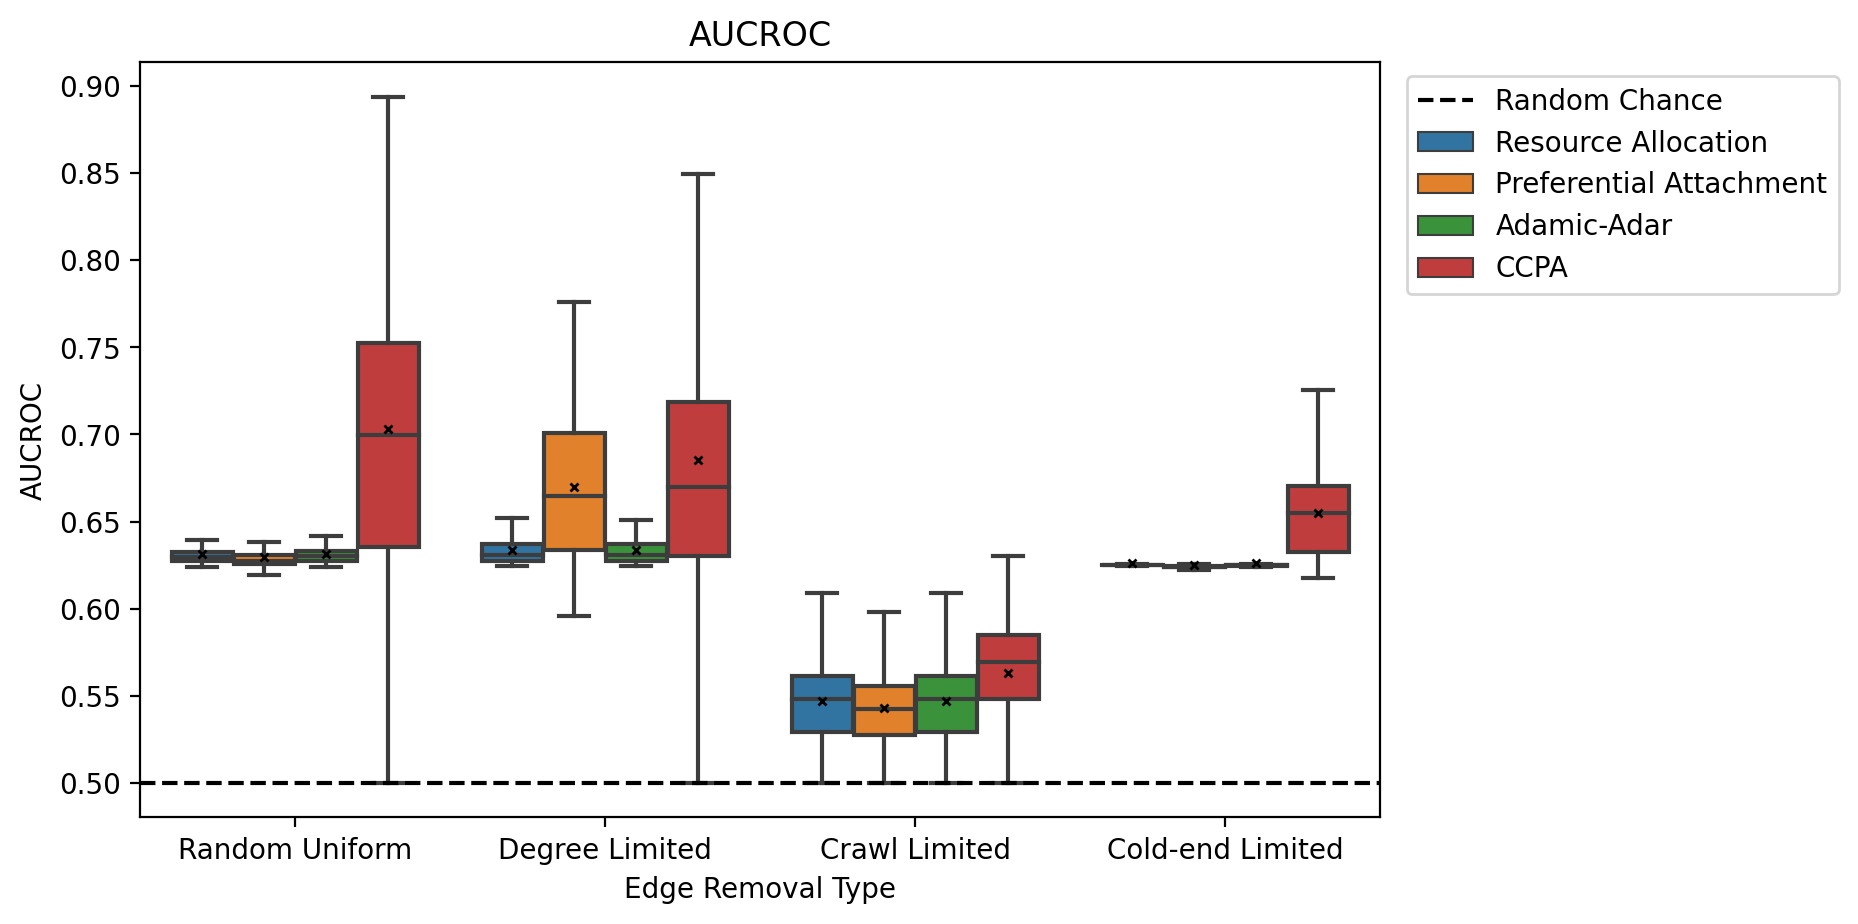

In [20]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()

sns.boxplot(data=df,
            x='missingType',
            hue='predictionAlgorithm',
            y='AUCROC',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})

plt.axhline(y=0.5, ls='--', c='k', label='Random Chance')

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('AUCROC')
plt.xlabel('Edge Removal Type')
plt.title('AUCROC')

plt.show()

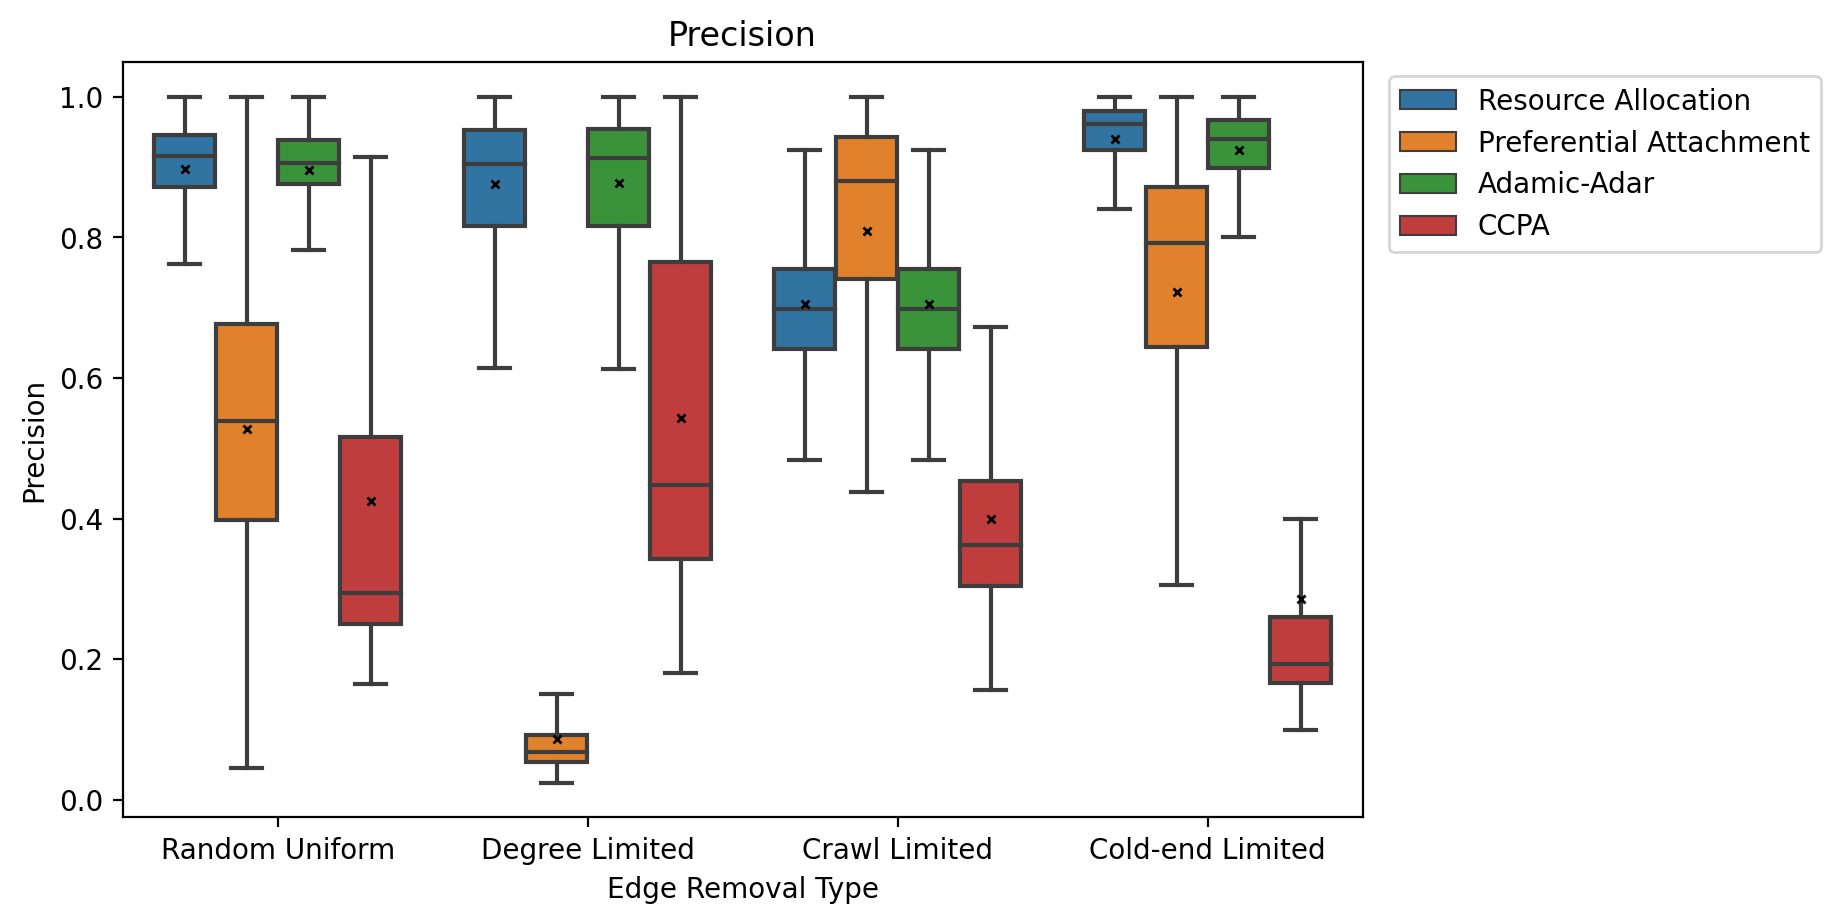

In [21]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()


sns.boxplot(data=df,
            x='missingType',
            hue='predictionAlgorithm',
            y='precision',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('Precision')
plt.xlabel('Edge Removal Type')
plt.title('Precision')

plt.show()

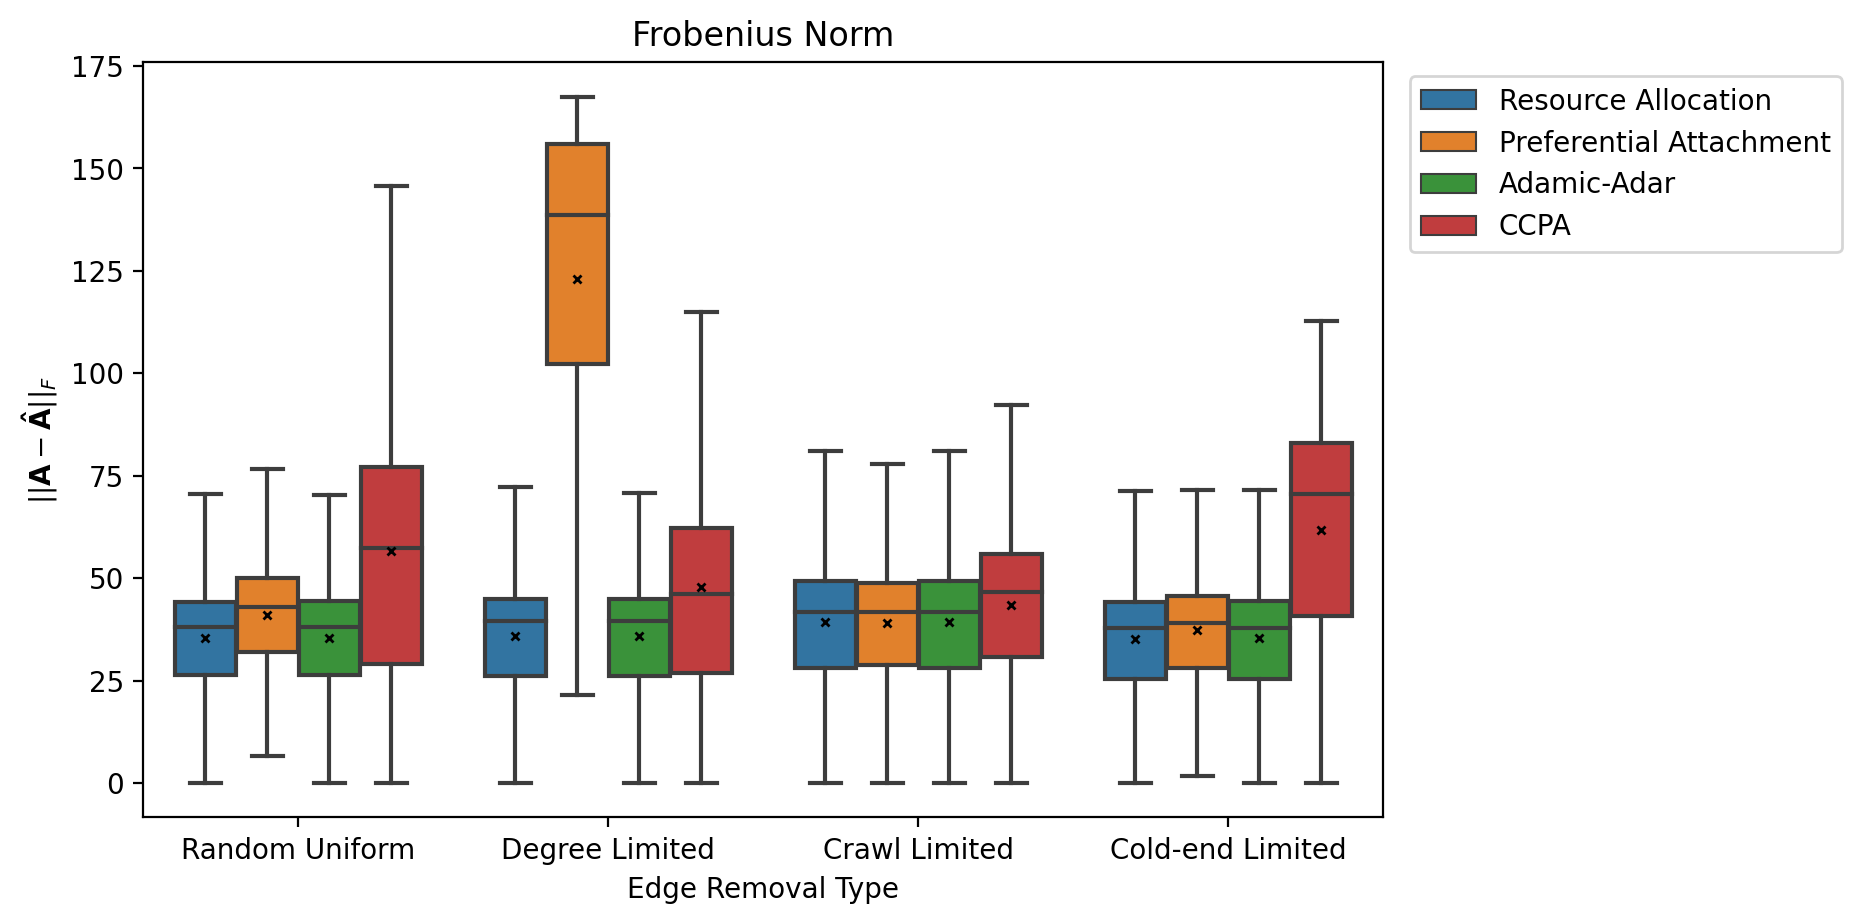

In [22]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()


sns.boxplot(data=df,
            x='missingType',
            hue='predictionAlgorithm',
            y='Fnorm',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})


plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('$||\mathbf{A} - \mathbf{\hat{A}}||_F$')
plt.xlabel('Edge Removal Type')
plt.title('Frobenius Norm')


plt.show()

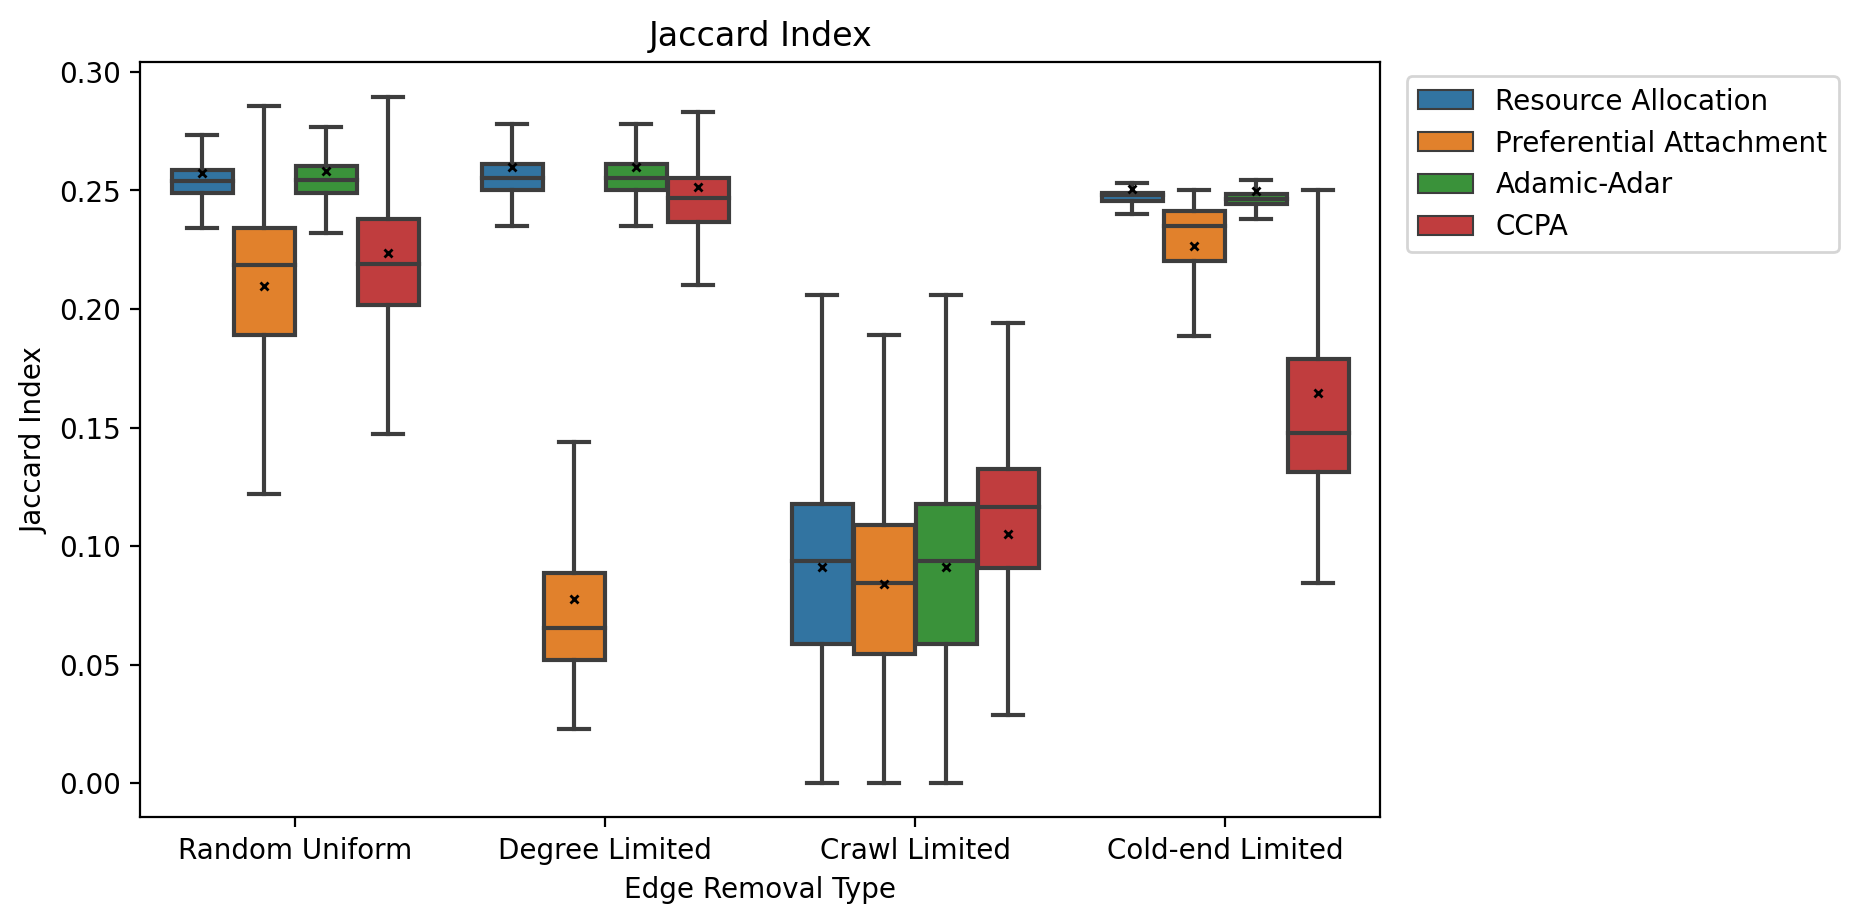

In [23]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()

sns.boxplot(data=df,
            x='missingType',
            hue='predictionAlgorithm',
            y='Jaccard_Index',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})


plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('Jaccard Index')
plt.xlabel('Edge Removal Type')
plt.title('Jaccard Index')


plt.show()

In [24]:
# break

In [25]:
grped = df.groupby(['missingType', 'predictionAlgorithm']).agg(
    JaccardMean=('Jaccard_Index', 'mean'),
    Jaccardstd=('Jaccard_Index', 'std'),
#     FnormMean=('Fnorm', 'mean'),
#     Fnormstd=('Fnorm', 'std'),
    AUCMean=('AUCROC', 'mean'),
    AUCstd=('AUCROC', 'std'),
).reset_index()

print(grped.round(3).to_latex(index=False))

\begin{tabular}{llrrrr}
\toprule
     missingType &     predictionAlgorithm &  JaccardMean &  Jaccardstd &  AUCMean &  AUCstd \\
\midrule
Cold-end Limited &             Adamic-Adar &        0.250 &       0.050 &    0.626 &   0.019 \\
Cold-end Limited &                    CCPA &        0.164 &       0.070 &    0.655 &   0.028 \\
Cold-end Limited & Preferential Attachment &        0.227 &       0.060 &    0.625 &   0.019 \\
Cold-end Limited &     Resource Allocation &        0.251 &       0.050 &    0.626 &   0.019 \\
   Crawl Limited &             Adamic-Adar &        0.091 &       0.077 &    0.547 &   0.035 \\
   Crawl Limited &                    CCPA &        0.105 &       0.075 &    0.563 &   0.038 \\
   Crawl Limited & Preferential Attachment &        0.084 &       0.075 &    0.543 &   0.034 \\
   Crawl Limited &     Resource Allocation &        0.091 &       0.077 &    0.547 &   0.035 \\
  Degree Limited &             Adamic-Adar &        0.260 &       0.050 &    0.634 &   0.020 \

In [26]:
df.columns

Index(['cell', 'predictionAlgorithm', 'missingType', 'Jaccard_Index', 'Fnorm',
       'AUCROC', 'MannUAUC', 'nTrue', 'nPred', 'TrueNegative', 'TruePositive',
       'FalseNegative', 'FalsePositive', 'sensitivity', 'specificity',
       'precision', 'falseDiscovery', 'predMatrix'],
      dtype='object')

In [27]:
df.to_csv('NaganoPredResults.csv', index=False)

In [28]:
# n = 100

# sampleKeys = np.random.choice(df['cell'], n)
# alg = 'Adamic-Adar' 
# train = 'Degree Limited'


# ensembleTrue = np.zeros((179, 179))
# ensemblePred = np.zeros((179, 179))

for key in sampleKeys:
    
    mask = (df['cell'] == key) & (df['predictionAlgorithm'] == alg) & (df['missingType'] == train)
    row = df.loc[mask]
    
    ensembleTrue += hic[key]
    ensemblePred += row['predMatrix'].values[0]
    


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig = plt.figure()

fig.add_subplot(121)
plt.imshow(ensembleTrue, cmap='binary')
plt.title(f'Ground Truth Data')

fig.add_subplot(122)
plt.imshow(ensemblePred, cmap='binary')
plt.title('Imputed Matrix')


NameError: name 'alg' is not defined